In [1]:
import cv2
import numpy as np
import scipy.ndimage as sn
from PIL import ImageEnhance, Image

def ObtainForegroundMask(image_path):
    """
    This function takes an image path as input, processes the image, 
    and returns the foreground mask using thresholding, morphological operations, and other filters.
    
    :param image_path: str, path to the input image
    :return: foreground mask (numpy array)
    """
    img = cv2.imread(image_path, 2)
    dst = cv2.fastNlMeansDenoising(img, None, 3, 7, 21)
    dst = Image.fromarray(dst)
    contrast = ImageEnhance.Contrast(dst)
    dst = contrast.enhance(1.5)
    dst = np.asarray(dst)
    dst2 = cv2.GaussianBlur(dst, (3, 3), 0)

    # Thresholding and morphological operations
    _, mask = cv2.threshold(dst2, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    kernel = np.ones((15, 15), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    kernel = np.ones((5, 5), np.uint8)
    mask = cv2.dilate(mask, kernel)
    mask = sn.binary_fill_holes(mask).astype('uint8')
    kernel = np.ones((9, 9), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    kernel = np.ones((11, 11), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    return mask


In [2]:
import copy
from skimage.feature import peak_local_max

def FindCellLocations(image_path, foreground_mask):
    """
    This function takes the RGB image path and the foreground mask, 
    and returns the approximate cell locations using a distance transform approach.
    
    :param image_path: str, path to the input image
    :param foreground_mask: numpy array, the foreground mask
    :return: list of coordinates representing cell locations
    """
    img = cv2.imread(image_path, 2)
    dst = cv2.fastNlMeansDenoising(img, None, 3, 7, 21)
    dst2 = cv2.GaussianBlur(dst, (3, 3), 0)

    # Apply thresholding to isolate foreground regions
    for row in range(dst2.shape[0]):
        for index in range(dst2.shape[1]):
            dst2[row][index] = 255 if dst2[row][index] > 195 else 0

    kernel = np.ones((3, 3), np.uint8)
    erosion = cv2.erode(dst2, kernel)
    new = copy.deepcopy(foreground_mask)

    # Remove foreground regions outside the eroded mask
    for row in range(dst2.shape[0]):
        for index in range(dst2.shape[1]):
            if erosion[row][index] == 255:
                new[row][index] = 0

    dist = cv2.distanceTransform(new, cv2.DIST_L2, 3)
    cv2.normalize(dist, dist, 0, 1.0, cv2.NORM_MINMAX)
    coordinates = peak_local_max(dist, min_distance=14)

    return coordinates


In [3]:
import copy
import cv2

def neighbors(coor, cell):
    """
    This function returns the neighboring pixels for a given cell location during region growing.
    
    :param coor: tuple, coordinates of the cell
    :param cell: int, the cell identifier
    :return: list of neighboring cells
    """
    neighbor = [[cell, int(coor[0]), int(coor[1])]]
    for c in range(-1, 2):
        for d in range(-1, 2):
            neighbor.append([cell, int(coor[0]) + c * 3, int(coor[1]) + d * 3])
    return neighbor

def FindCellBoundaries(image_path, foreground_mask, cell_locations):
    """
    This function performs region growing to segment cells in the image using foreground mask and cell locations.
    
    :param image_path: str, path to the input image
    :param foreground_mask: numpy array, the foreground mask
    :param cell_locations: list, coordinates of cell locations
    :return: segmented image with cells labeled
    """
    img = cv2.imread(image_path, 2)
    dst = cv2.fastNlMeansDenoising(img, None, 3, 7, 21)
    dst2 = cv2.GaussianBlur(dst, (3, 3), 0)

    # Prepare region growing
    part_3 = copy.deepcopy(foreground_mask).astype(int)
    for row in range(part_3.shape[0]):
        for index in range(part_3.shape[1]):
            if part_3[row][index] == 1:
                part_3[row][index] = -1

    regions = []
    checked = []

    part_3 = np.pad(part_3, ((3, 3), (3, 3)), 'constant')

    for cell_id in range(len(cell_locations)):
        regions.extend(neighbors(cell_locations[cell_id], cell_id + 1))

    while regions:
        e = regions[0][0]
        x = regions[0][1]
        y = regions[0][2]
        checked.append(regions[0])
        
        if part_3[x + 3][y + 3] == -1:
            for c in range(-2, 3):
                for d in range(-2, 3):
                    part_3[x + c + 3][y + d + 3] = e
            neighs = neighbors([x, y], e)
            for e in neighs:
                if e not in checked:
                    regions.append(e)
        
        regions.pop(0)

    part_3 = part_3[3:-3, 3:-3]

    for row in range(part_3.shape[0]):
        for index in range(part_3.shape[1]):
            if part_3[row][index] == -1:
                part_3[row][index] = 0

    return part_3


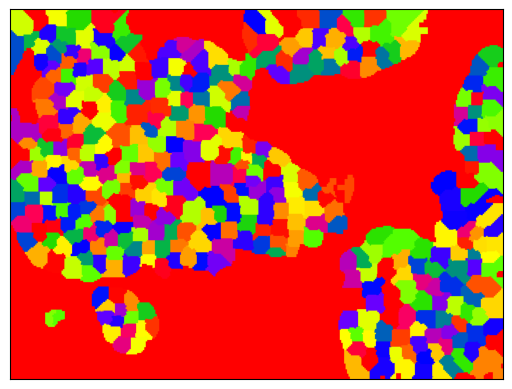

In [ ]:
import matplotlib.pyplot as plt


# Load data files
data_mask = np.loadtxt("im3_gold_mask.txt")
data_coor = np.loadtxt("im3_gold_cells.txt")

# Part 1: Obtain Foreground Mask
foreground_mask = ObtainForegroundMask('im3.jpg')

# Part 2: Find Cell Locations
cell_locations = FindCellLocations('im3.jpg', foreground_mask)

# Part 3: Find Cell Boundaries
segmentation_map = FindCellBoundaries('im3.jpg', foreground_mask, cell_locations)


# Visualize segmentation result
plt.imshow(segmentation_map, cmap='prism')
plt.xticks([]), plt.yticks([])
plt.show()


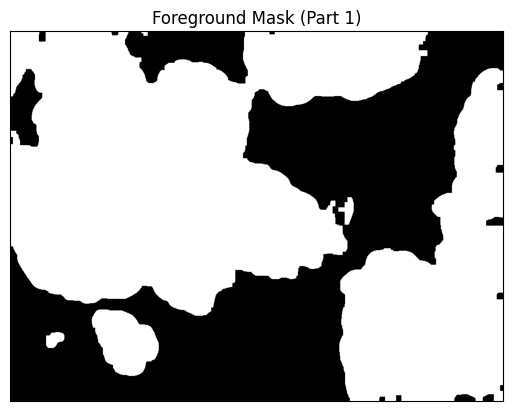

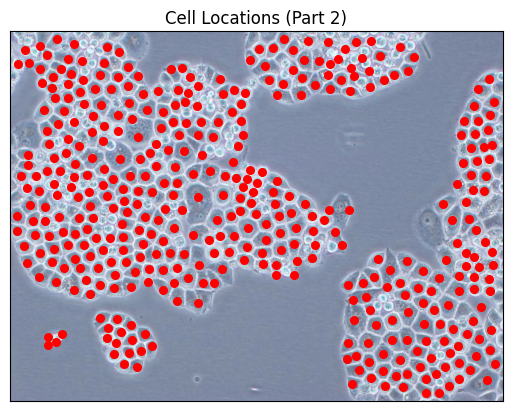

KeyboardInterrupt: 

In [7]:
import cv2
import numpy as np
import scipy.ndimage as sn
from PIL import ImageEnhance, Image
import matplotlib.pyplot as plt
import copy
from skimage.feature import peak_local_max

# Part 1: ObtainForegroundMask function
def ObtainForegroundMask(image_path):
    """
    This function takes an image path as input, processes the image, 
    and returns the foreground mask using thresholding, morphological operations, and other filters.
    """
    img = cv2.imread(image_path, 2)
    dst = cv2.fastNlMeansDenoising(img, None, 3, 7, 21)
    dst = Image.fromarray(dst)
    contrast = ImageEnhance.Contrast(dst)
    dst = contrast.enhance(1.5)
    dst = np.asarray(dst)
    dst2 = cv2.GaussianBlur(dst, (3, 3), 0)

    # Thresholding and morphological operations
    _, mask = cv2.threshold(dst2, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    kernel = np.ones((15, 15), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    kernel = np.ones((5, 5), np.uint8)
    mask = cv2.dilate(mask, kernel)
    mask = sn.binary_fill_holes(mask).astype('uint8')
    kernel = np.ones((9, 9), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    kernel = np.ones((11, 11), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    return mask

# Part 2: FindCellLocations function
def FindCellLocations(image_path, foreground_mask):
    """
    This function takes the RGB image path and the foreground mask, 
    and returns the approximate cell locations using a distance transform approach.
    """
    img = cv2.imread(image_path, 2)
    dst = cv2.fastNlMeansDenoising(img, None, 3, 7, 21)
    dst2 = cv2.GaussianBlur(dst, (3, 3), 0)

    # Apply thresholding to isolate foreground regions
    dst2[dst2 > 195] = 255
    dst2[dst2 <= 195] = 0

    kernel = np.ones((3, 3), np.uint8)
    erosion = cv2.erode(dst2, kernel)
    new = copy.deepcopy(foreground_mask)

    # Remove foreground regions outside the eroded mask
    new[erosion == 255] = 0

    dist = cv2.distanceTransform(new, cv2.DIST_L2, 3)
    cv2.normalize(dist, dist, 0, 1.0, cv2.NORM_MINMAX)
    coordinates = peak_local_max(dist, min_distance=14)

    return coordinates

# Part 3: FindCellBoundaries function
def neighbors(coor, cell):
    """
    This function returns the neighboring pixels for a given cell location during region growing.
    """
    neighbor = [[cell, int(coor[0]), int(coor[1])]]
    for c in range(-1, 2):
        for d in range(-1, 2):
            neighbor.append([cell, int(coor[0]) + c * 3, int(coor[1]) + d * 3])
    return neighbor

def FindCellBoundaries(image_path, foreground_mask, cell_locations):
    """
    This function performs region growing to segment cells in the image using foreground mask and cell locations.
    """
    img = cv2.imread(image_path, 2)
    dst = cv2.fastNlMeansDenoising(img, None, 3, 7, 21)
    dst2 = cv2.GaussianBlur(dst, (3, 3), 0)

    # Prepare region growing
    part_3 = copy.deepcopy(foreground_mask).astype(int)
    for row in range(part_3.shape[0]):
        for index in range(part_3.shape[1]):
            if part_3[row][index] == 1:
                part_3[row][index] = -1

    regions = []
    checked = []

    part_3 = np.pad(part_3, ((3, 3), (3, 3)), 'constant')

    for cell_id in range(len(cell_locations)):
        regions.extend(neighbors(cell_locations[cell_id], cell_id + 1))

    while regions:
        e = regions[0][0]
        x = regions[0][1]
        y = regions[0][2]
        checked.append(regions[0])
        
        if part_3[x + 3][y + 3] == -1:
            for c in range(-2, 3):
                for d in range(-2, 3):
                    part_3[x + c + 3][y + d + 3] = e
            neighs = neighbors([x, y], e)
            for e in neighs:
                if e not in checked:
                    regions.append(e)
        
        regions.pop(0)

    part_3 = part_3[3:-3, 3:-3]

    for row in range(part_3.shape[0]):
        for index in range(part_3.shape[1]):
            if part_3[row][index] == -1:
                part_3[row][index] = 0

    return part_3

# Load data files
data_mask = np.loadtxt("im3_gold_mask.txt")
data_coor = np.loadtxt("im3_gold_cells.txt")

# Part 1: Obtain Foreground Mask
foreground_mask = ObtainForegroundMask('im3.jpg')

# Plot Part 1: Foreground Mask
plt.imshow(foreground_mask, cmap='gray')
plt.title("Foreground Mask (Part 1)")
plt.xticks([]), plt.yticks([])  # Hide ticks
plt.show()

# Part 2: Find Cell Locations
cell_locations = FindCellLocations('im3.jpg', foreground_mask)

# Plot Part 2: Cell Locations
img = cv2.imread('im3.jpg')
plt.imshow(img)
plt.scatter(cell_locations[:, 1], cell_locations[:, 0], c='r', marker='o', s=30)
plt.title("Cell Locations (Part 2)")
plt.xticks([]), plt.yticks([])  # Hide ticks
plt.show()

# Part 3: Find Cell Boundaries
segmentation_map = FindCellBoundaries('im3.jpg', foreground_mask, cell_locations)

# Plot Part 3: Segmentation Map
plt.imshow(segmentation_map, cmap='prism')
plt.title("Segmentation Map (Part 3)")
plt.xticks([]), plt.yticks([])  # Hide ticks
plt.show()


Part 1 Metrics for im1.jpg:
Precision: 0.81
Recall: 0.97
Fscore: 0.88



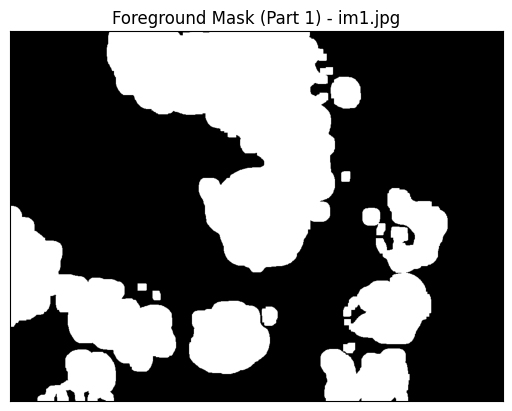

Part 2 Metrics for im1.jpg:
Precision: 0.79
Recall: 0.83
Fscore: 0.81



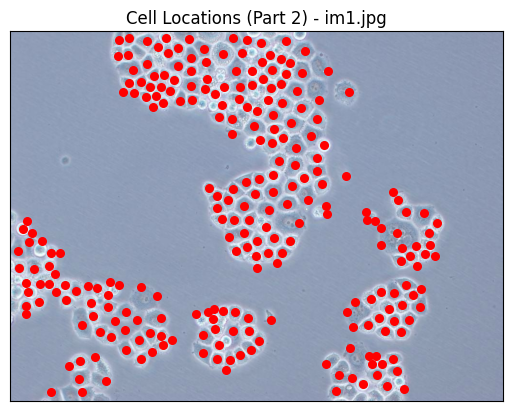

Part 3 Metrics for im1.jpg:
Dice: 0.37
IoU: 0.22



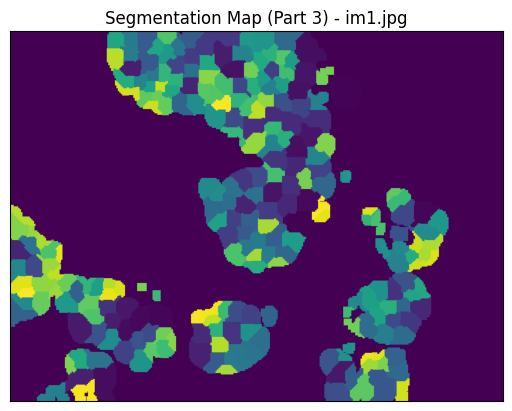

Part 1 Metrics for im2.jpg:
Precision: 0.85
Recall: 0.99
Fscore: 0.91



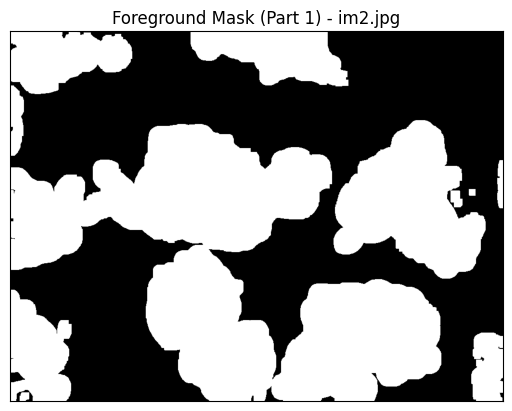

Part 2 Metrics for im2.jpg:
Precision: 0.86
Recall: 0.87
Fscore: 0.87



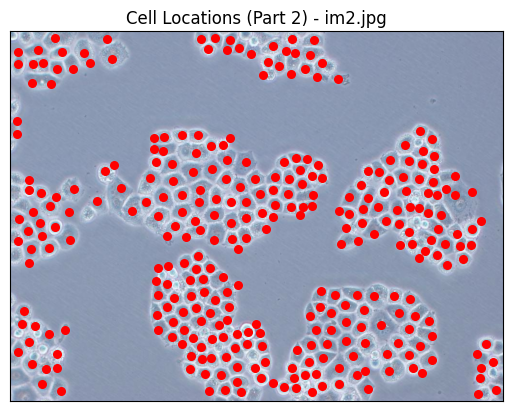

Part 3 Metrics for im2.jpg:
Dice: 0.47
IoU: 0.31



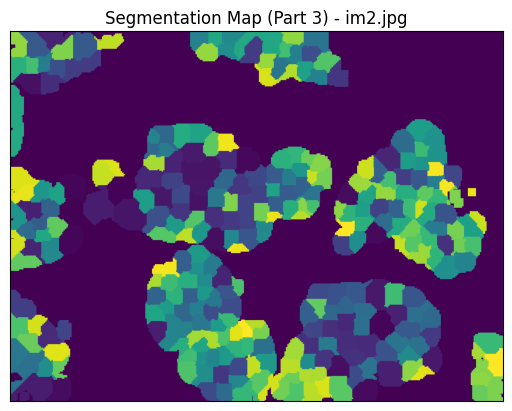

Part 1 Metrics for im3.jpg:
Precision: 0.93
Recall: 0.99
Fscore: 0.96



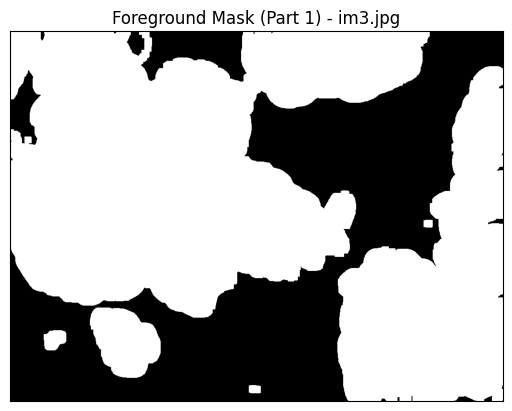

Part 2 Metrics for im3.jpg:
Precision: 0.92
Recall: 0.76
Fscore: 0.83



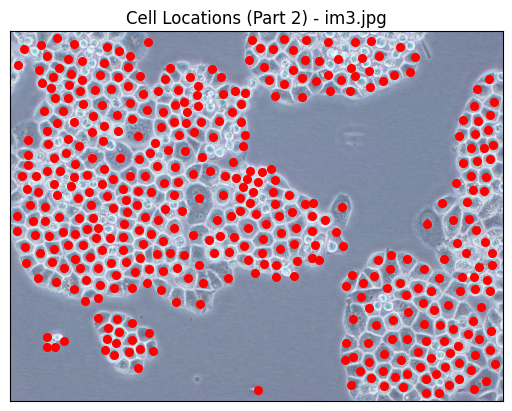

In [ ]:
import cv2
import numpy as np
import scipy.ndimage as sn
from PIL import ImageEnhance, Image
import matplotlib.pyplot as plt
import copy
from skimage.feature import peak_local_max

# Part 1: ObtainForegroundMask function
import cv2
import numpy as np
import scipy.ndimage as sn

def ObtainForegroundMask(image_path):
    """
    This function takes an image path as input, processes the image to segment the foreground
    and returns the foreground mask using thresholding and morphological operations.
    """
    # read the image in grayscale
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # apply Gaussian blur --> a preprocessing method to reduce noise and  smooth the image
    blurred_image = cv2.GaussianBlur(image, (5, 5), 0) # 5x5 is size of the window used to compute the average

    #  Otsu's method --> useful for auto thresholding to separate foreground from background
    _, foreground_mask = cv2.threshold(blurred_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    #  morphological closing (dilation +  erosion) to fill gaps
    kernel = np.ones((7, 7), np.uint8) #creates a square mask of ones of size 7x7
    foreground_mask = cv2.morphologyEx(foreground_mask, cv2.MORPH_CLOSE, kernel)

    #  dilation to expand the foreground regions (optional step for better segmentation)
    foreground_mask = cv2.dilate(foreground_mask, kernel, iterations=2)
    
    # ** Dilation  expands the boundaries of the foreground regions helps to connecting nearby foreground objects that might have been separated during thresholding
    
    foreground_mask = sn.binary_fill_holes(foreground_mask).astype(np.uint8)

    return foreground_mask


import cv2
import numpy as np
from skimage.feature import peak_local_max

def FindCellLocations(image_path, foreground_mask):
    """
    This function takes the grayscale image path and the foreground mask,
    and returns the approximate locations of cells using a distance transform approach.
    """
   
    gray_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

   
    blurred_image = cv2.GaussianBlur(gray_image, (3, 3), 0)

    # isolate potential foreground regions
    _, thresholded_image = cv2.threshold(blurred_image, 195, 255, cv2.THRESH_BINARY) #converts the blurred image into a binary image 
    #any pixel value above 195 is set to 255 to assign it to foreground

    # erode the thresholded image to remove small unwanted regions
    eroded_image = cv2.erode(thresholded_image, np.ones((3, 3), np.uint8))

    #*** erosion****
    #Erosion removes small foreground objects like noise, making the segmentation cleaner and focusing on the true cells.

    # remove regions outside the foreground mask 
    foreground_mask_copy = foreground_mask.copy()
    foreground_mask_copy[eroded_image == 255] = 0

    # perform distance transform to highlight areas closer to foreground objects
    distance_transform = cv2.distanceTransform(foreground_mask_copy, cv2.DIST_L2, 5)
    #******* distance transform
    #distance transform is a process that computes the distance from every background pixel to the nearest foreground pixel which useful for highlighting regions that are closer to foreground objects
    # helps highlight the centers of objects 


    # normalization :  intensity values of the distance transform are mapped to a uniform range
    cv2.normalize(distance_transform, distance_transform, 0, 1.0, cv2.NORM_MINMAX)

    # find local maxima in the distance transform (cell locations)
    cell_locations = peak_local_max(distance_transform, min_distance=14)

    return cell_locations


import cv2
import numpy as np
import copy
import matplotlib.pyplot as plt

def get_neighbors(coord, cell_id):
    """
    This function returns the neighboring pixels for a given cell location during region growing.
    The neighbors are within a 3x3 grid surrounding the given coordinate.
    """
    neighbors = [[cell_id, coord[0], coord[1]]]
    for dx in range(-1, 2):
        for dy in range(-1, 2):
            neighbors.append([cell_id, coord[0] + dx * 3, coord[1] + dy * 3])
    return neighbors


def FindCellBoundaries(image_path, foreground_mask, cell_locations):
    """
    This function performs region growing to segment cells in the image using foreground mask 
    and initial cell locations. It returns the segmented boundaries of cells in the form of a mask.
    """
    image_gray = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image_blurred = cv2.GaussianBlur(image_gray, (3, 3), 0)

    # prepare the mask for region growing
    mask = foreground_mask.astype(int)
    mask[mask == 1] = -1  # Mark foreground regions with -1

    # pad the mask ( this is used to avoid boundary issues during region growing)
    padded_mask = np.pad(mask, ((3, 3), (3, 3)), mode='constant', constant_values=0)

    regions_to_process = []
    visited_cells = []

    # START region growing with the given cell locations
    for cell_id, coord in enumerate(cell_locations, start=1):
        regions_to_process.extend(get_neighbors(coord, cell_id))

    # **REGION GROWING***
    while regions_to_process:
        cell_id, x, y = regions_to_process.pop(0)  

        visited_cells.append([cell_id, x, y])

        if padded_mask[x + 3, y + 3] == -1:
            for dx in range(-2, 3):
                for dy in range(-2, 3):
                    padded_mask[x + dx + 3, y + dy + 3] = cell_id  # assign cell id to neighbors

            # adding neighbors to regions_to_process
            new_neighbors = get_neighbors([x, y], cell_id)
            for neighbor in new_neighbors:
                if neighbor not in visited_cells:
                    regions_to_process.append(neighbor)

    segmented_mask = padded_mask[3:-3, 3:-3]  # remove padding
    segmented_mask[segmented_mask == -1] = 0  # set all unprocessed cells to background (0)

    return segmented_mask


import cv2
import numpy as np
import matplotlib.pyplot as plt

def load_gold_data(mask_path, cells_path):
    """
    Load the gold standard mask and cell coordinates data.
    """
    data_mask = np.loadtxt(mask_path)
    data_coor = np.loadtxt(cells_path)
    return data_mask, data_coor

def process_images(image_paths, gold_mask_paths, gold_cells_paths):
    """
    Processes multiple images by calculating foreground mask, cell locations, 
    and segmentation boundaries, and then printing metrics and displaying plots for each.
    """

    for img_idx, image_path in enumerate(image_paths):
       
        data_mask, data_coor = load_gold_data(gold_mask_paths[img_idx], gold_cells_paths[img_idx])

        # Part 1: Obtain Foreground Mask
        foreground_mask = ObtainForegroundMask(image_path)

        # Metrics for Part 1: Foreground Mask
        TP = np.sum((foreground_mask == 1) & (data_mask == 1))
        FP = np.sum((foreground_mask == 1) & (data_mask == 0))
        FN = np.sum((foreground_mask == 0) & (data_mask == 1))

        prec = TP / (TP + FP)
        recall = TP / (TP + FN)
        Fscore = TP / (TP + (1/2 * (FP + FN)))

        print(f'Part 1 Metrics for {image_path}:')
        print(f"Precision: {prec:.2f}")
        print(f"Recall: {recall:.2f}")
        print(f"Fscore: {Fscore:.2f}\n")

        # Plot Part 1: Foreground Mask
        plt.imshow(foreground_mask, cmap='gray')
        plt.title(f"Foreground Mask (Part 1) - {image_path}")
        plt.xticks([]), plt.yticks([])  # Hide ticks
        plt.show()

        # Part 2: Find Cell Locations
        cell_locations = FindCellLocations(image_path, foreground_mask)

        # Metrics for Part 2: Cell Locations
        TP_2 = 0
        cells = []
        for x, y in cell_locations:
            cells = np.append(cells, data_coor[int(x)][int(y)])

        val = 999
        dup = 0
        for c in range(cells.size):
            if val != cells[c] and cells[c] != 0:
                TP_2 += 1
                dup = 0
            if val == cells[c] and cells[c] != 0:
                dup = 1
            val = cells[c]
        TP_2 -= dup

        prec_2 = TP_2 / cells.size
        recall_2 = TP_2 / data_coor.max()
        Fscore_2 = (2 * prec_2 * recall_2) / (prec_2 + recall_2)

        print(f'Part 2 Metrics for {image_path}:')
        print(f"Precision: {prec_2:.2f}")
        print(f"Recall: {recall_2:.2f}")
        print(f"Fscore: {Fscore_2:.2f}\n")

        # Plot Part 2: Cell Locations
        img = cv2.imread(image_path)
        plt.imshow(img)
        plt.scatter(cell_locations[:, 1], cell_locations[:, 0], c='r', marker='o', s=30)
        plt.title(f"Cell Locations (Part 2) - {image_path}")
        plt.xticks([]), plt.yticks([])  # Hide ticks
        plt.show()

        # Part 3: Find Cell Boundaries
        segmentation_map = FindCellBoundaries(image_path, foreground_mask, cell_locations)

        # Metrics for Part 3: Dice and IoU
        TP_3 = 0
        FP_3 = 0
        FN_3 = 0
        for row in range(segmentation_map.shape[0]):
            for index in range(segmentation_map.shape[1]):
                if segmentation_map[row][index] == 1 and data_mask[row][index] == 1:
                    TP_3 += 1
                if segmentation_map[row][index] == 1 and data_mask[row][index] == 0:
                    FP_3 += 1
                if segmentation_map[row][index] == 0 and data_mask[row][index] == 1:
                    FN_3 += 1

        Dice = 2 * TP_3 / (2 * TP_3 + FP_3 + FN_3)
        IoU = TP_3 / (TP_3 + FP_3 + FN_3)

        print(f'Part 3 Metrics for {image_path}:')
        print(f"Dice: {Dice:.2f}")
        print(f"IoU: {IoU:.2f}\n")

        # Plot Part 3: Segmentation Map 
        plt.imshow(segmentation_map, cmap='viridis')  # Change to a different colormap
        plt.title(f"Segmentation Map (Part 3) - {image_path}")
        plt.xticks([]), plt.yticks([])  # Hide ticks
        plt.show()


image_paths = ['im1.jpg', 'im2.jpg', 'im3.jpg']
gold_mask_paths = ['im1_gold_mask.txt', 'im2_gold_mask.txt', 'im3_gold_mask.txt']
gold_cells_paths = ['im1_gold_cells.txt', 'im2_gold_cells.txt', 'im3_gold_cells.txt']


process_images(image_paths, gold_mask_paths, gold_cells_paths)





In [ ]:
import cv2
import numpy as np
import scipy.ndimage as sn
from PIL import ImageEnhance, Image
import matplotlib.pyplot as plt
import copy
from skimage.feature import peak_local_max

# Part 1: ObtainForegroundMask function
import cv2
import numpy as np
import scipy.ndimage as sn

def ObtainForegroundMask(image_path):
    """
    This function takes an image path as input, processes the image to segment the foreground
    and returns the foreground mask using thresholding and morphological operations.
    """
    # read the image in grayscale
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # apply Gaussian blur --> a preprocessing method to reduce noise
    blurred_image = cv2.GaussianBlur(image, (5, 5), 0)

    #  Otsu's method for automatic thresholding to separate foreground from background
    _, foreground_mask = cv2.threshold(blurred_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Apply morphological closing (dilation followed by erosion) to fill gaps
    kernel = np.ones((7, 7), np.uint8)
    foreground_mask = cv2.morphologyEx(foreground_mask, cv2.MORPH_CLOSE, kernel)

   

    
    foreground_mask = sn.binary_fill_holes(foreground_mask).astype(np.uint8)

    return foreground_mask


import cv2
import numpy as np
from skimage.feature import peak_local_max

def FindCellLocations(image_path, foreground_mask):
    """
    This function takes the grayscale image path and the foreground mask,
    and returns the approximate locations of cells using a distance transform approach.
    """
    # Read the grayscale image
    gray_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Apply Gaussian blur to reduce noise in the image
    blurred_image = cv2.GaussianBlur(gray_image, (3, 3), 0)

    # Threshold the image to isolate potential foreground regions
    _, thresholded_image = cv2.threshold(blurred_image, 195, 255, cv2.THRESH_BINARY)

    # Erode the thresholded image to remove small unwanted regions
    eroded_image = cv2.erode(thresholded_image, np.ones((3, 3), np.uint8))

    # Remove regions outside the foreground mask by setting them to zero
    foreground_mask_copy = foreground_mask.copy()
    foreground_mask_copy[eroded_image == 255] = 0

    # Perform distance transform to highlight areas closer to foreground objects
    distance_transform = cv2.distanceTransform(foreground_mask_copy, cv2.DIST_L2, 5)

    # Normalize the distance transform for better contrast
    cv2.normalize(distance_transform, distance_transform, 0, 1.0, cv2.NORM_MINMAX)

    # Find local maxima in the distance transform (cell locations)
    cell_locations = peak_local_max(distance_transform, min_distance=14)

    return cell_locations


import cv2
import numpy as np
import copy
import matplotlib.pyplot as plt

def get_neighbors(coord, cell_id):
    """
    This function returns the neighboring pixels for a given cell location during region growing.
    The neighbors are within a 3x3 grid surrounding the given coordinate.
    """
    neighbors = [[cell_id, coord[0], coord[1]]]
    for dx in range(-1, 2):
        for dy in range(-1, 2):
            neighbors.append([cell_id, coord[0] + dx * 3, coord[1] + dy * 3])
    return neighbors


def FindCellBoundaries(image_path, foreground_mask, cell_locations):
    """
    This function performs region growing to segment cells in the image using foreground mask 
    and initial cell locations. It returns the segmented boundaries of cells in the form of a mask.
    """
    image_gray = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image_blurred = cv2.GaussianBlur(image_gray, (3, 3), 0)

    # Prepare the mask for region growing
    mask = foreground_mask.astype(int)
    mask[mask == 1] = -1  # Mark foreground regions with -1

    # Pad the mask to avoid boundary issues during region growing
    padded_mask = np.pad(mask, ((3, 3), (3, 3)), mode='constant', constant_values=0)

    regions_to_process = []
    visited_cells = []

    # Initialize region growing with the given cell locations
    for cell_id, coord in enumerate(cell_locations, start=1):
        regions_to_process.extend(get_neighbors(coord, cell_id))

    # Perform region growing
    while regions_to_process:
        cell_id, x, y = regions_to_process.pop(0)  # Get the first region to process

        visited_cells.append([cell_id, x, y])

        if padded_mask[x + 3, y + 3] == -1:
            for dx in range(-2, 3):
                for dy in range(-2, 3):
                    padded_mask[x + dx + 3, y + dy + 3] = cell_id  # Assign cell ID to neighbors

            # Add neighbors to regions_to_process
            new_neighbors = get_neighbors([x, y], cell_id)
            for neighbor in new_neighbors:
                if neighbor not in visited_cells:
                    regions_to_process.append(neighbor)

    segmented_mask = padded_mask[3:-3, 3:-3]  # Remove padding
    segmented_mask[segmented_mask == -1] = 0  # Set all unprocessed cells to background (0)

    return segmented_mask


import cv2
import numpy as np
import matplotlib.pyplot as plt

def load_gold_data(mask_path, cells_path):
    """
    Load the gold standard mask and cell coordinates data.
    """
    data_mask = np.loadtxt(mask_path)
    data_coor = np.loadtxt(cells_path)
    return data_mask, data_coor

def process_images(image_paths, gold_mask_paths, gold_cells_paths):
    """
    Processes multiple images by calculating foreground mask, cell locations, 
    and segmentation boundaries, and then printing metrics and displaying plots for each.
    """

    for img_idx, image_path in enumerate(image_paths):
       
        data_mask, data_coor = load_gold_data(gold_mask_paths[img_idx], gold_cells_paths[img_idx])

        # Part 1: Obtain Foreground Mask
        foreground_mask = ObtainForegroundMask(image_path)

        # Metrics for Part 1: Foreground Mask
        TP = np.sum((foreground_mask == 1) & (data_mask == 1))
        FP = np.sum((foreground_mask == 1) & (data_mask == 0))
        FN = np.sum((foreground_mask == 0) & (data_mask == 1))

        prec = TP / (TP + FP)
        recall = TP / (TP + FN)
        Fscore = TP / (TP + (1/2 * (FP + FN)))

        print(f'Part 1 Metrics for {image_path}:')
        print(f"Precision: {prec:.2f}")
        print(f"Recall: {recall:.2f}")
        print(f"Fscore: {Fscore:.2f}\n")

        # Plot Part 1: Foreground Mask
        plt.imshow(foreground_mask, cmap='gray')
        plt.title(f"Foreground Mask (Part 1) - {image_path}")
        plt.xticks([]), plt.yticks([])  # Hide ticks
        plt.show()

        # Part 2: Find Cell Locations
        cell_locations = FindCellLocations(image_path, foreground_mask)

        # Metrics for Part 2: Cell Locations
        TP_2 = 0
        cells = []
        for x, y in cell_locations:
            cells = np.append(cells, data_coor[int(x)][int(y)])

        val = 999
        dup = 0
        for c in range(cells.size):
            if val != cells[c] and cells[c] != 0:
                TP_2 += 1
                dup = 0
            if val == cells[c] and cells[c] != 0:
                dup = 1
            val = cells[c]
        TP_2 -= dup

        prec_2 = TP_2 / cells.size
        recall_2 = TP_2 / data_coor.max()
        Fscore_2 = (2 * prec_2 * recall_2) / (prec_2 + recall_2)

        print(f'Part 2 Metrics for {image_path}:')
        print(f"Precision: {prec_2:.2f}")
        print(f"Recall: {recall_2:.2f}")
        print(f"Fscore: {Fscore_2:.2f}\n")

        # Plot Part 2: Cell Locations
        img = cv2.imread(image_path)
        plt.imshow(img)
        plt.scatter(cell_locations[:, 1], cell_locations[:, 0], c='r', marker='o', s=30)
        plt.title(f"Cell Locations (Part 2) - {image_path}")
        plt.xticks([]), plt.yticks([])  # Hide ticks
        plt.show()

        # Part 3: Find Cell Boundaries
        segmentation_map = FindCellBoundaries(image_path, foreground_mask, cell_locations)

        # Metrics for Part 3: Dice and IoU
        TP_3 = 0
        FP_3 = 0
        FN_3 = 0
        for row in range(segmentation_map.shape[0]):
            for index in range(segmentation_map.shape[1]):
                if segmentation_map[row][index] == 1 and data_mask[row][index] == 1:
                    TP_3 += 1
                if segmentation_map[row][index] == 1 and data_mask[row][index] == 0:
                    FP_3 += 1
                if segmentation_map[row][index] == 0 and data_mask[row][index] == 1:
                    FN_3 += 1

        Dice = 2 * TP_3 / (2 * TP_3 + FP_3 + FN_3)
        IoU = TP_3 / (TP_3 + FP_3 + FN_3)

        print(f'Part 3 Metrics for {image_path}:')
        print(f"Dice: {Dice:.2f}")
        print(f"IoU: {IoU:.2f}\n")

        # Plot Part 3: Segmentation Map 
        plt.imshow(segmentation_map, cmap='viridis')  # Change to a different colormap
        plt.title(f"Segmentation Map (Part 3) - {image_path}")
        plt.xticks([]), plt.yticks([])  # Hide ticks
        plt.show()


image_paths = ['im1.jpg', 'im2.jpg', 'im3.jpg']
gold_mask_paths = ['im1_gold_mask.txt', 'im2_gold_mask.txt', 'im3_gold_mask.txt']
gold_cells_paths = ['im1_gold_cells.txt', 'im2_gold_cells.txt', 'im3_gold_cells.txt']


process_images(image_paths, gold_mask_paths, gold_cells_paths)





Part 1 Metrics for im1.jpg:
Precision: 0.81
Recall: 0.97
Fscore: 0.88



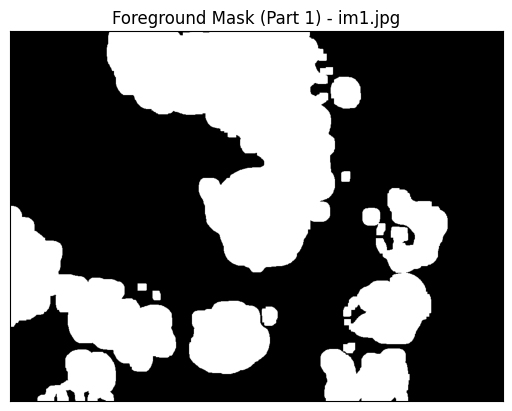

Part 2 Metrics for im1.jpg:
Precision: 0.79
Recall: 0.83
Fscore: 0.81



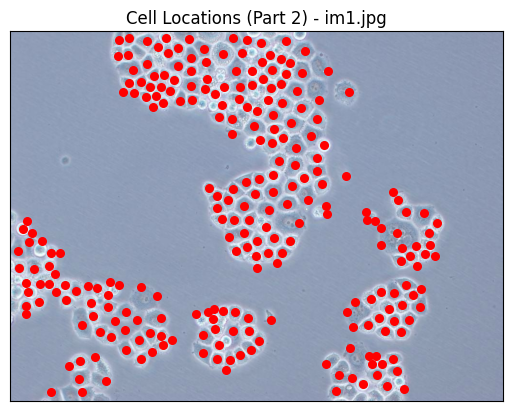

Part 3 Metrics for im1.jpg:
Dice: 0.37
IoU: 0.22



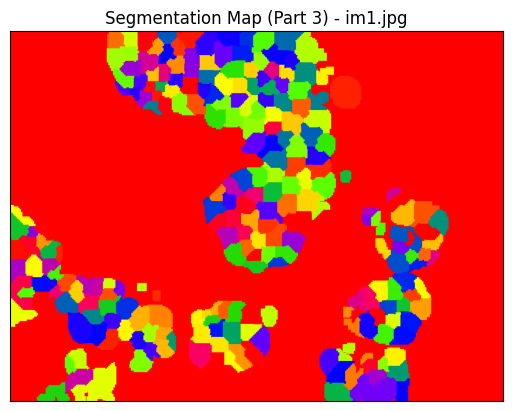

Part 1 Metrics for im2.jpg:
Precision: 0.85
Recall: 0.99
Fscore: 0.91



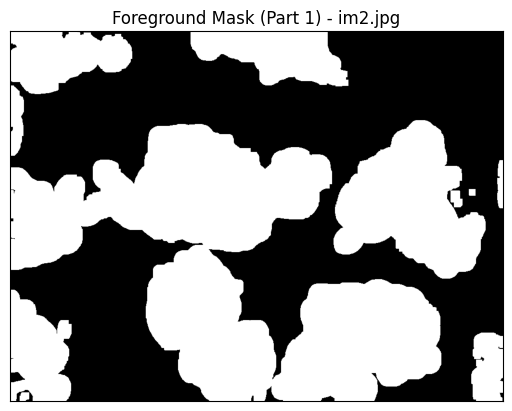

Part 2 Metrics for im2.jpg:
Precision: 0.86
Recall: 0.87
Fscore: 0.87



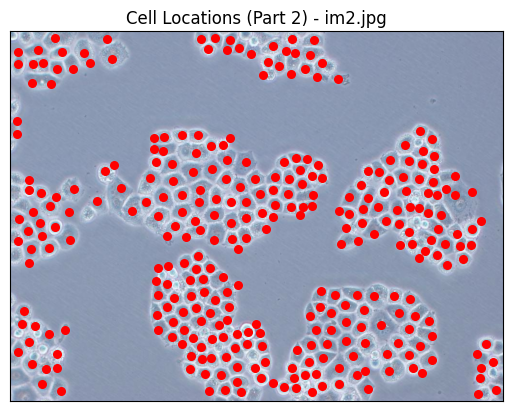

KeyboardInterrupt: 

In [19]:
import cv2
import numpy as np
import copy

def get_neighbors(coord, cell_id):
    """
    This function returns the neighboring pixels for a given cell location during region growing.
    The neighbors are within a 3x3 grid surrounding the given coordinate.
    """
    # Initialize neighbors list with the current coordinate itself
    neighbors = [[cell_id, coord[0], coord[1]]]

    # Generate neighboring coordinates for the 3x3 grid
    for dx in range(-1, 2):  # from -1 to 1 (both inclusive)
        for dy in range(-1, 2):  # from -1 to 1 (both inclusive)
            # Append each neighbor's coordinates scaled by 3 (for the region growing)
            neighbors.append([cell_id, coord[0] + dx * 3, coord[1] + dy * 3])
    
    return neighbors


def FindCellBoundaries(image_path, foreground_mask, cell_locations):
    """
    This function performs region growing to segment cells in the image using foreground mask 
    and initial cell locations. It returns the segmented boundaries of cells in the form of a mask.
    """
    # Step 1: Load the grayscale image and apply Gaussian blur
    image_gray = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image_blurred = cv2.GaussianBlur(image_gray, (3, 3), 0)

    # Step 2: Prepare the mask for region growing (initialize it with -1 for the foreground)
    mask = foreground_mask.astype(int)
    mask[mask == 1] = -1  # Mark foreground regions with -1

    # Step 3: Pad the mask to avoid boundary issues during region growing
    padded_mask = np.pad(mask, ((3, 3), (3, 3)), mode='constant', constant_values=0)

    # Step 4: Initialize region growing with the given cell locations
    regions_to_process = []
    visited_cells = []

    # Add initial cell locations to the list of regions to process
    for cell_id, coord in enumerate(cell_locations, start=1):
        regions_to_process.extend(get_neighbors(coord, cell_id))

    # Step 5: Perform region growing by processing each region in the list
    while regions_to_process:
        cell_id, x, y = regions_to_process.pop(0)  # Get the first region to process

        # Mark the current cell as visited
        visited_cells.append([cell_id, x, y])

        # Grow the region by checking its neighbors
        if padded_mask[x + 3, y + 3] == -1:
            for dx in range(-2, 3):  # For each neighbor in a 5x5 grid
                for dy in range(-2, 3):
                    padded_mask[x + dx + 3, y + dy + 3] = cell_id  # Assign cell ID to neighbors
            
            # Add the neighbors of the current cell to the regions to process
            new_neighbors = get_neighbors([x, y], cell_id)
            for neighbor in new_neighbors:
                if neighbor not in visited_cells:
                    regions_to_process.append(neighbor)

    # Step 6: Crop the padded mask and set all unprocessed cells back to 0
    segmented_mask = padded_mask[3:-3, 3:-3]  # Remove padding
    segmented_mask[segmented_mask == -1] = 0  # Set all unprocessed cells to background (0)

    return segmented_mask

#****************************************** RESULTS
import cv2
import numpy as np
import matplotlib.pyplot as plt

# List of image paths to process
image_paths = ['im1.jpg', 'im2.jpg', 'im3.jpg']
gold_mask_paths = ['im1_gold_mask.txt', 'im2_gold_mask.txt', 'im3_gold_mask.txt']
gold_cells_paths = ['im1_gold_cells.txt', 'im2_gold_cells.txt', 'im3_gold_cells.txt']

# Function to load gold standard data files
def load_gold_data(mask_path, cells_path):
    data_mask = np.loadtxt(mask_path)
    data_coor = np.loadtxt(cells_path)
    return data_mask, data_coor

# Loop over all images
for img_idx, image_path in enumerate(image_paths):
    # Load data files
    data_mask, data_coor = load_gold_data(gold_mask_paths[img_idx], gold_cells_paths[img_idx])

    # Part 1: Obtain Foreground Mask
    foreground_mask = ObtainForegroundMask(image_path)

    # Metrics for Part 1: Foreground Mask
    TP = np.sum((foreground_mask == 1) & (data_mask == 1))
    FP = np.sum((foreground_mask == 1) & (data_mask == 0))
    FN = np.sum((foreground_mask == 0) & (data_mask == 1))

    prec = TP / (TP + FP)
    recall = TP / (TP + FN)
    Fscore = TP / (TP + (1/2 * (FP + FN)))

    print(f'Part 1 Metrics for {image_path}:')
    print(f"Precision: {prec:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"Fscore: {Fscore:.2f}\n")

    # Plot Part 1: Foreground Mask
    plt.imshow(foreground_mask, cmap='gray')
    plt.title(f"Foreground Mask (Part 1) - {image_path}")
    plt.xticks([]), plt.yticks([])  # Hide ticks
    plt.show()

    # Part 2: Find Cell Locations
    cell_locations = FindCellLocations(image_path, foreground_mask)

    # Metrics for Part 2: Cell Locations
    TP_2 = 0
    cells = []
    for x, y in cell_locations:
        cells = np.append(cells, data_coor[int(x)][int(y)])

    # Count True Positives (TP), False Positives (FP), and duplicates in cells
    val = 999
    dup = 0
    for c in range(cells.size):
        if val != cells[c] and cells[c] != 0:
            TP_2 += 1
            dup = 0
        if val == cells[c] and cells[c] != 0:
            dup = 1
        val = cells[c]
    TP_2 -= dup

    prec_2 = TP_2 / cells.size
    recall_2 = TP_2 / data_coor.max()
    Fscore_2 = (2 * prec_2 * recall_2) / (prec_2 + recall_2)

    print(f'Part 2 Metrics for {image_path}:')
    print(f"Precision: {prec_2:.2f}")
    print(f"Recall: {recall_2:.2f}")
    print(f"Fscore: {Fscore_2:.2f}\n")

    # Plot Part 2: Cell Locations
    img = cv2.imread(image_path)
    plt.imshow(img)
    plt.scatter(cell_locations[:, 1], cell_locations[:, 0], c='r', marker='o', s=30)
    plt.title(f"Cell Locations (Part 2) - {image_path}")
    plt.xticks([]), plt.yticks([])  # Hide ticks
    plt.show()

    # Part 3: Find Cell Boundaries
    segmentation_map = FindCellBoundaries(image_path, foreground_mask, cell_locations)

    # Metrics for Part 3: Dice and IoU
    TP_3 = 0
    FP_3 = 0
    FN_3 = 0
    for row in range(segmentation_map.shape[0]):
        for index in range(segmentation_map.shape[1]):
            if segmentation_map[row][index] == 1 and data_mask[row][index] == 1:
                TP_3 += 1
            if segmentation_map[row][index] == 1 and data_mask[row][index] == 0:
                FP_3 += 1
            if segmentation_map[row][index] == 0 and data_mask[row][index] == 1:
                FN_3 += 1

    Dice = 2 * TP_3 / (2 * TP_3 + FP_3 + FN_3)
    IoU = TP_3 / (TP_3 + FP_3 + FN_3)

    print(f'Part 3 Metrics for {image_path}:')
    print(f"Dice: {Dice:.2f}")
    print(f"IoU: {IoU:.2f}\n")

    # Plot Part 3: Segmentation Map
    plt.imshow(segmentation_map, cmap='prism')
    plt.title(f"Segmentation Map (Part 3) - {image_path}")
    plt.xticks([]), plt.yticks([])  # Hide ticks
    plt.show()







Part 1 Metrics for im1.jpg:
Precision: 0.81
Recall: 0.97
Fscore: 0.88



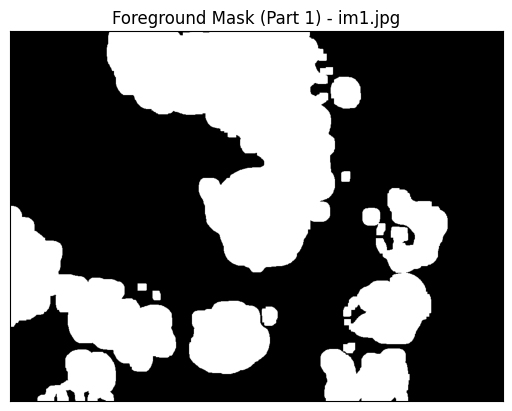

Part 2 Metrics for im1.jpg:
Precision: 0.79
Recall: 0.83
Fscore: 0.81



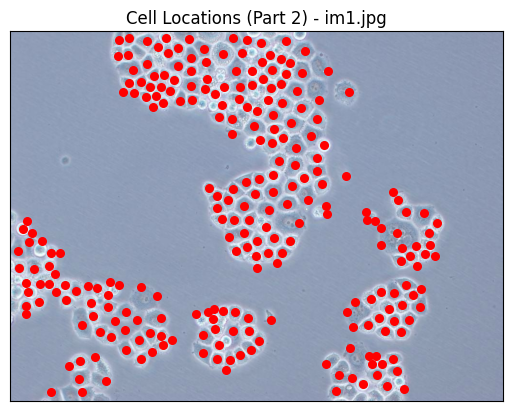

Part 3 Metrics for im1.jpg:
Dice: 0.37
IoU: 0.22



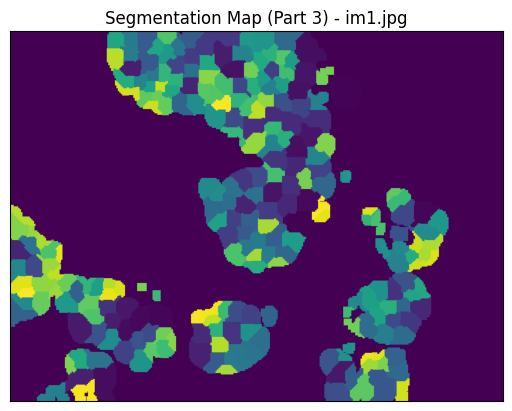

Part 1 Metrics for im2.jpg:
Precision: 0.85
Recall: 0.99
Fscore: 0.91



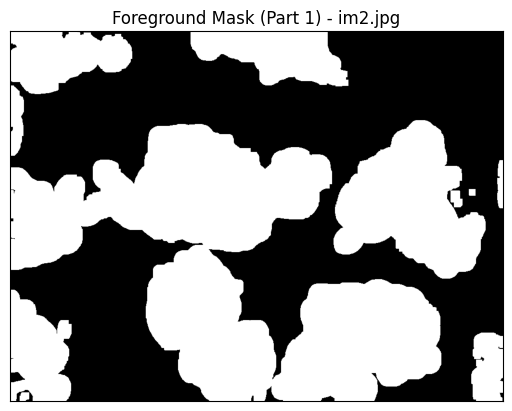

Part 2 Metrics for im2.jpg:
Precision: 0.86
Recall: 0.87
Fscore: 0.87



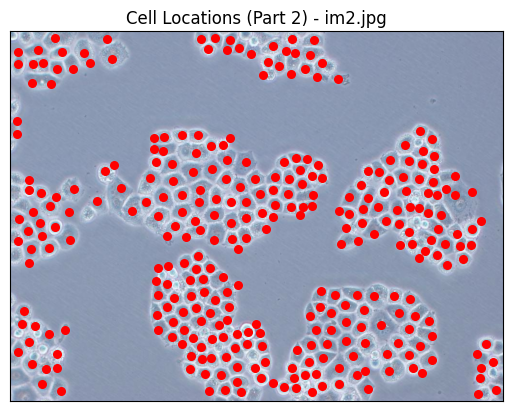

KeyboardInterrupt: 

In [20]:
import cv2
import numpy as np
import copy
import matplotlib.pyplot as plt

def get_neighbors(coord, cell_id):
    """
    This function returns the neighboring pixels for a given cell location during region growing.
    The neighbors are within a 3x3 grid surrounding the given coordinate.
    """
    neighbors = [[cell_id, coord[0], coord[1]]]
    for dx in range(-1, 2):
        for dy in range(-1, 2):
            neighbors.append([cell_id, coord[0] + dx * 3, coord[1] + dy * 3])
    return neighbors


def FindCellBoundaries(image_path, foreground_mask, cell_locations):
    """
    This function performs region growing to segment cells in the image using foreground mask 
    and initial cell locations. It returns the segmented boundaries of cells in the form of a mask.
    """
    image_gray = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image_blurred = cv2.GaussianBlur(image_gray, (3, 3), 0)

    # Prepare the mask for region growing
    mask = foreground_mask.astype(int)
    mask[mask == 1] = -1  # Mark foreground regions with -1

    # Pad the mask to avoid boundary issues during region growing
    padded_mask = np.pad(mask, ((3, 3), (3, 3)), mode='constant', constant_values=0)

    regions_to_process = []
    visited_cells = []

    # Initialize region growing with the given cell locations
    for cell_id, coord in enumerate(cell_locations, start=1):
        regions_to_process.extend(get_neighbors(coord, cell_id))

    # Perform region growing
    while regions_to_process:
        cell_id, x, y = regions_to_process.pop(0)  # Get the first region to process

        visited_cells.append([cell_id, x, y])

        if padded_mask[x + 3, y + 3] == -1:
            for dx in range(-2, 3):
                for dy in range(-2, 3):
                    padded_mask[x + dx + 3, y + dy + 3] = cell_id  # Assign cell ID to neighbors

            # Add neighbors to regions_to_process
            new_neighbors = get_neighbors([x, y], cell_id)
            for neighbor in new_neighbors:
                if neighbor not in visited_cells:
                    regions_to_process.append(neighbor)

    segmented_mask = padded_mask[3:-3, 3:-3]  # Remove padding
    segmented_mask[segmented_mask == -1] = 0  # Set all unprocessed cells to background (0)

    return segmented_mask


# Results
image_paths = ['im1.jpg', 'im2.jpg', 'im3.jpg']
gold_mask_paths = ['im1_gold_mask.txt', 'im2_gold_mask.txt', 'im3_gold_mask.txt']
gold_cells_paths = ['im1_gold_cells.txt', 'im2_gold_cells.txt', 'im3_gold_cells.txt']

# Load gold standard data files
def load_gold_data(mask_path, cells_path):
    data_mask = np.loadtxt(mask_path)
    data_coor = np.loadtxt(cells_path)
    return data_mask, data_coor

# Loop over all images
for img_idx, image_path in enumerate(image_paths):
    # Load data files
    data_mask, data_coor = load_gold_data(gold_mask_paths[img_idx], gold_cells_paths[img_idx])

    # Part 1: Obtain Foreground Mask
    foreground_mask = ObtainForegroundMask(image_path)

    # Metrics for Part 1: Foreground Mask
    TP = np.sum((foreground_mask == 1) & (data_mask == 1))
    FP = np.sum((foreground_mask == 1) & (data_mask == 0))
    FN = np.sum((foreground_mask == 0) & (data_mask == 1))

    prec = TP / (TP + FP)
    recall = TP / (TP + FN)
    Fscore = TP / (TP + (1/2 * (FP + FN)))

    print(f'Part 1 Metrics for {image_path}:')
    print(f"Precision: {prec:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"Fscore: {Fscore:.2f}\n")

    # Plot Part 1: Foreground Mask
    plt.imshow(foreground_mask, cmap='gray')
    plt.title(f"Foreground Mask (Part 1) - {image_path}")
    plt.xticks([]), plt.yticks([])  # Hide ticks
    plt.show()

    # Part 2: Find Cell Locations
    cell_locations = FindCellLocations(image_path, foreground_mask)

    # Metrics for Part 2: Cell Locations
    TP_2 = 0
    cells = []
    for x, y in cell_locations:
        cells = np.append(cells, data_coor[int(x)][int(y)])

    val = 999
    dup = 0
    for c in range(cells.size):
        if val != cells[c] and cells[c] != 0:
            TP_2 += 1
            dup = 0
        if val == cells[c] and cells[c] != 0:
            dup = 1
        val = cells[c]
    TP_2 -= dup

    prec_2 = TP_2 / cells.size
    recall_2 = TP_2 / data_coor.max()
    Fscore_2 = (2 * prec_2 * recall_2) / (prec_2 + recall_2)

    print(f'Part 2 Metrics for {image_path}:')
    print(f"Precision: {prec_2:.2f}")
    print(f"Recall: {recall_2:.2f}")
    print(f"Fscore: {Fscore_2:.2f}\n")

    # Plot Part 2: Cell Locations
    img = cv2.imread(image_path)
    plt.imshow(img)
    plt.scatter(cell_locations[:, 1], cell_locations[:, 0], c='r', marker='o', s=30)
    plt.title(f"Cell Locations (Part 2) - {image_path}")
    plt.xticks([]), plt.yticks([])  # Hide ticks
    plt.show()

    # Part 3: Find Cell Boundaries
    segmentation_map = FindCellBoundaries(image_path, foreground_mask, cell_locations)

    # Metrics for Part 3: Dice and IoU
    TP_3 = 0
    FP_3 = 0
    FN_3 = 0
    for row in range(segmentation_map.shape[0]):
        for index in range(segmentation_map.shape[1]):
            if segmentation_map[row][index] == 1 and data_mask[row][index] == 1:
                TP_3 += 1
            if segmentation_map[row][index] == 1 and data_mask[row][index] == 0:
                FP_3 += 1
            if segmentation_map[row][index] == 0 and data_mask[row][index] == 1:
                FN_3 += 1

    Dice = 2 * TP_3 / (2 * TP_3 + FP_3 + FN_3)
    IoU = TP_3 / (TP_3 + FP_3 + FN_3)

    print(f'Part 3 Metrics for {image_path}:')
    print(f"Dice: {Dice:.2f}")
    print(f"IoU: {IoU:.2f}\n")

    # Plot Part 3: Segmentation Map with a different colormap
    plt.imshow(segmentation_map, cmap='viridis')  # Change to a different colormap
    plt.title(f"Segmentation Map (Part 3) - {image_path}")
    plt.xticks([]), plt.yticks([])  # Hide ticks
    plt.show()


In [ ]:
# tidied up 

import cv2
import numpy as np
import matplotlib.pyplot as plt

def load_gold_data(mask_path, cells_path):
    """
    Load the gold standard mask and cell coordinates data.
    """
    data_mask = np.loadtxt(mask_path)
    data_coor = np.loadtxt(cells_path)
    return data_mask, data_coor

def process_images(image_paths, gold_mask_paths, gold_cells_paths):
    """
    Processes multiple images by calculating foreground mask, cell locations, 
    and segmentation boundaries, and then printing metrics and displaying plots for each.
    """

    for img_idx, image_path in enumerate(image_paths):
       
        data_mask, data_coor = load_gold_data(gold_mask_paths[img_idx], gold_cells_paths[img_idx])

        # Part 1: Obtain Foreground Mask
        foreground_mask = ObtainForegroundMask(image_path)

        # Metrics for Part 1: Foreground Mask
        TP = np.sum((foreground_mask == 1) & (data_mask == 1))
        FP = np.sum((foreground_mask == 1) & (data_mask == 0))
        FN = np.sum((foreground_mask == 0) & (data_mask == 1))

        prec = TP / (TP + FP)
        recall = TP / (TP + FN)
        Fscore = TP / (TP + (1/2 * (FP + FN)))

        print(f'Part 1 Metrics for {image_path}:')
        print(f"Precision: {prec:.2f}")
        print(f"Recall: {recall:.2f}")
        print(f"Fscore: {Fscore:.2f}\n")

        # Plot Part 1: Foreground Mask
        plt.imshow(foreground_mask, cmap='gray')
        plt.title(f"Foreground Mask (Part 1) - {image_path}")
        plt.xticks([]), plt.yticks([])  # Hide ticks
        plt.show()

        # Part 2: Find Cell Locations
        cell_locations = FindCellLocations(image_path, foreground_mask)

        # Metrics for Part 2: Cell Locations
        TP_2 = 0
        cells = []
        for x, y in cell_locations:
            cells = np.append(cells, data_coor[int(x)][int(y)])

        val = 999
        dup = 0
        for c in range(cells.size):
            if val != cells[c] and cells[c] != 0:
                TP_2 += 1
                dup = 0
            if val == cells[c] and cells[c] != 0:
                dup = 1
            val = cells[c]
        TP_2 -= dup

        prec_2 = TP_2 / cells.size
        recall_2 = TP_2 / data_coor.max()
        Fscore_2 = (2 * prec_2 * recall_2) / (prec_2 + recall_2)

        print(f'Part 2 Metrics for {image_path}:')
        print(f"Precision: {prec_2:.2f}")
        print(f"Recall: {recall_2:.2f}")
        print(f"Fscore: {Fscore_2:.2f}\n")

        # Plot Part 2: Cell Locations
        img = cv2.imread(image_path)
        plt.imshow(img)
        plt.scatter(cell_locations[:, 1], cell_locations[:, 0], c='r', marker='o', s=30)
        plt.title(f"Cell Locations (Part 2) - {image_path}")
        plt.xticks([]), plt.yticks([])  # Hide ticks
        plt.show()

        # Part 3: Find Cell Boundaries
        segmentation_map = FindCellBoundaries(image_path, foreground_mask, cell_locations)

        # Metrics for Part 3: Dice and IoU
        TP_3 = 0
        FP_3 = 0
        FN_3 = 0
        for row in range(segmentation_map.shape[0]):
            for index in range(segmentation_map.shape[1]):
                if segmentation_map[row][index] == 1 and data_mask[row][index] == 1:
                    TP_3 += 1
                if segmentation_map[row][index] == 1 and data_mask[row][index] == 0:
                    FP_3 += 1
                if segmentation_map[row][index] == 0 and data_mask[row][index] == 1:
                    FN_3 += 1

        Dice = 2 * TP_3 / (2 * TP_3 + FP_3 + FN_3)
        IoU = TP_3 / (TP_3 + FP_3 + FN_3)

        print(f'Part 3 Metrics for {image_path}:')
        print(f"Dice: {Dice:.2f}")
        print(f"IoU: {IoU:.2f}\n")

        # Plot Part 3: Segmentation Map 
        plt.imshow(segmentation_map, cmap='viridis')  # Change to a different colormap
        plt.title(f"Segmentation Map (Part 3) - {image_path}")
        plt.xticks([]), plt.yticks([])  # Hide ticks
        plt.show()


image_paths = ['im1.jpg', 'im2.jpg', 'im3.jpg']
gold_mask_paths = ['im1_gold_mask.txt', 'im2_gold_mask.txt', 'im3_gold_mask.txt']
gold_cells_paths = ['im1_gold_cells.txt', 'im2_gold_cells.txt', 'im3_gold_cells.txt']


process_images(image_paths, gold_mask_paths, gold_cells_paths)
